SENTIMENT ANALYSIS FOR DATASET https://huggingface.co/datasets/alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad

In [6]:
### LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import pipeline

nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joey_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
## DATA SOURCE (DATASETS)

full_train_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")
full_test_dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="test")

# Seleccionar 30% aleatorio de cada conjunto
train_dataset = full_train_dataset.shuffle(seed=42).select(range(int(0.01 * len(full_train_dataset))))
test_dataset = full_test_dataset.shuffle(seed=42).select(range(int(0.01 * len(full_test_dataset))))

test_proportion = len(test_dataset) / (len(train_dataset) + len(test_dataset))

print(f"Train Dataset: {len(train_dataset)}, Test Dataset: {len(test_dataset)}, Test Set Proportion: {test_proportion:.2%}")

Train Dataset: 1761, Test Dataset: 755, Test Set Proportion: 30.01%


In [8]:
## DATAFRAMES

train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

print(train_df.head(5), "\n", test_df.head(5))


                                                text  label
0  recuerdos de colonial. el zócalo es la plaza c...      5
1  me encanto el fuerte!. wow wow wow!!! excelent...      5
2  descansa y camina. en el corazón angelopolitan...      4
3  la mejor vista. tiene una vista fuera de serie...      5
4  la historia es aquí. qué contraste de la vieja...      4 
                                                 text  label
0  centrico y pintoresco. he ido varias veces, lu...      3
1  paseo inolvidable. fue un paseo muy bonito, en...      5
2  el paseo dura 30 minutos aprox.. si deseas adq...      4
3  muy buen hotel para estándares cubanos. las ha...      4
4  cumpleaños. muy buena la comida y excelente se...      5


In [9]:
### MODELO PRE-ENTRENADO "BERT"

# Verificar etiquetas originales
print("Etiquetas únicas en train (original):", set(train_dataset["label"]))
print("Etiquetas únicas en test (original):", set(test_dataset["label"]))

# Ajustar etiquetas solo para el modelo (1-5 a 0-4)
def adjust_labels_for_model(dataset):
    def adjust_label(example):
        label = example["label"]
        if label not in [1, 2, 3, 4, 5]:  # Si está fuera de 1-5, asignamos 3 (Neutral)
            print(f"Etiqueta inválida encontrada: {label}, asignando 3")
            return {"label": 3 - 1}  # Ajustamos a 2
        return {"label": label - 1}  # Ajustamos de 1-5 a 0-4
    return dataset.map(adjust_label, num_proc=4)

train_dataset = adjust_labels_for_model(train_dataset)
test_dataset = adjust_labels_for_model(test_dataset)

# Verificar etiquetas ajustadas
print("Etiquetas únicas en train (ajustadas para modelo):", set(train_dataset["label"]))
print("Etiquetas únicas en test (ajustadas para modelo):", set(test_dataset["label"]))


model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # "nlptown/bert-base-multilingual-uncased-sentiment" #Funciona para varios idiomas, nlptown es mejor, pero mi PC es una tortuga
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#Tokenización

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64) #Reducido de 512 a 256 por la tortuga

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#Transformación de etiquetas para el formato PyTorch

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Etiquetas únicas en train (original): {1, 2, 3, 4, 5}
Etiquetas únicas en test (original): {1, 2, 3, 4, 5}
Etiquetas únicas en train (ajustadas para modelo): {0, 1, 2, 3, 4}
Etiquetas únicas en test (ajustadas para modelo): {0, 1, 2, 3, 4}


Map:   0%|          | 0/755 [00:00<?, ? examples/s]

In [10]:
### TRAINING

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    learning_rate=3e-10,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=12,
    num_train_epochs=0.5,
    weight_decay=0.01,
    fp16=False,  # Desactivado para CPU
    dataloader_num_workers=2,  # Ajusto según mis núcleos 
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=None
)

# Entrenar
trainer.train()



Step,Training Loss
10,0.763900
20,0.776700
30,0.782500
40,0.883700
50,0.845800
60,0.783000
70,0.774500
80,0.739700


TrainOutput(global_step=89, training_loss=0.791138225726867, metrics={'train_runtime': 1793.9166, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.05, 'total_flos': 29271893349120.0, 'train_loss': 0.791138225726867, 'epoch': 0.5028248587570622})

In [11]:
# Evaluación optimizada para CPU
model.eval()
device = torch.device("cpu")
model.to(device)

# Crear DataLoader optimizado
test_dataloader = DataLoader(
    test_dataset,
    batch_size=10,  # Ajusta según tu RAM y núcleos
    shuffle=False,
    num_workers=2,  # Ajusta según tus núcleos
    pin_memory=False  # No necesario en CPU
)

all_preds = []
all_labels = []

# Evaluación rápida
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(batch["labels"].numpy())

# Convertir de 0-4 a 1-5
pred_labels = np.array(all_preds) + 1
true_labels = np.array(all_labels) + 1

# Calcular métricas
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Precisión del modelo: {accuracy:.2%}")
print("\nReporte de clasificación (1-5):")
print(classification_report(true_labels, pred_labels, target_names=["1", "2", "3", "4", "5"]))

Precisión del modelo: 66.62%

Reporte de clasificación (1-5):
              precision    recall  f1-score   support

           1       0.33      0.79      0.47        14
           2       0.25      0.45      0.32        22
           3       0.50      0.38      0.43        64
           4       0.44      0.34      0.38       175
           5       0.80      0.83      0.81       480

    accuracy                           0.67       755
   macro avg       0.46      0.56      0.48       755
weighted avg       0.67      0.67      0.66       755



In [16]:
### SENTIMENT ANALYSIS

sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
df = pd.concat([train_df, test_df])

def analyze_sentiment(comment):
    comment = str(comment).strip()
    if not comment or comment == "nan":
        return "Neutral", 0.0
    
    result = sentiment_analyzer(comment, truncation=True, max_length=512)[0]
    label_str = result['label']
    score = result['score']
    
    # Handle different possible label formats
    try:
        # Try to extract number from labels like "LABEL_0", "LABEL_1", etc.
        if 'LABEL_' in label_str:
            label = int(label_str.split('_')[-1]) + 1
        # Handle star ratings like "5 stars"
        elif 'stars' in label_str.lower():
            label = int(label_str.split()[0])
        # Handle direct numbers
        else:
            label = int(label_str) + 1
    except (ValueError, IndexError):
        # Fallback: infer label from score if label format is unexpected
        if score > 0.7:
            label = 5
        elif score > 0.5:
            label = 4
        elif score > 0.3:
            label = 3
        elif score > 0.1:
            label = 2
        else:
            label = 1

    # Ensure label is within 1-5 range
    label = max(1, min(5, label))
    
    if label in [4, 5]:
        sentiment = "Positive"
        polarity = score
    elif label == 3:
        sentiment = "Neutral"
        polarity = 0.0
    elif label in [1, 2]:
        sentiment = "Negative"
        polarity = -score
    
    return sentiment, polarity

test_df[['sentiment', 'polarity']] = test_df["text"].apply(analyze_sentiment).apply(pd.Series)
print("\nDistribución de sentimientos en el conjunto de prueba:")
print(test_df['sentiment'].value_counts())

Device set to use cpu



Distribución de sentimientos en el conjunto de prueba:
sentiment
Positive    656
Neutral      55
Negative     44
Name: count, dtype: int64


In [17]:
### ENTRENAMIENTO DE CONTEXTOS PARA CLASIFICAR MAIN TOPICS

predefined_issues = {
    "Retrasos en Servicios": ["lento", "tardado", "espera", "demora", "llegar", "retraso"],
    "Mala Atención al Cliente": ["grosero", "mala", "atención", "ayuda", "incompetente", "amable"],
    "Problemas de Calidad": ["sucio", "malo", "suciedad", "calidad", "pésimo", "roto"],
    "Fraude o Seguridad": ["estafa", "fraude", "seguridad", "confianza", "engaño", "robo"],
    "Costos Elevados": ["caro", "precio", "costoso", "dinero", "pagar", "tarifa"],
    "Infraestructura Deficiente": ["instalaciones", "baño", "habitación", "sucio", "mantenimiento", "roto"],
    "Falta de Información": ["información", "comunicación", "respuesta", "contestar", "claro", "duda"],
    "Problemas de Reservación": ["reserva", "cancelar", "booking", "disponible", "error", "confirmación"],
    "Excelente Servicio": ["excelente", "rápido", "amable", "servicio", "atención", "genial"],
    "Buena Calidad": ["limpio", "bonito", "calidad", "cómodo", "agradable", "perfecto"],
    "Precios Justos": ["barato", "justo", "precio", "económico", "accesible", "valor"],
    "Experiencia Memorable": ["inolvidable", "maravilloso", "hermoso", "disfrutar", "fantástico", "recomiendo"]
}

In [18]:
### CLASIFICACIÓN DE TOPICOS

def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Otros"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap:
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Otros"

test_df['issue'] = test_df["text"].apply(assign_issue)

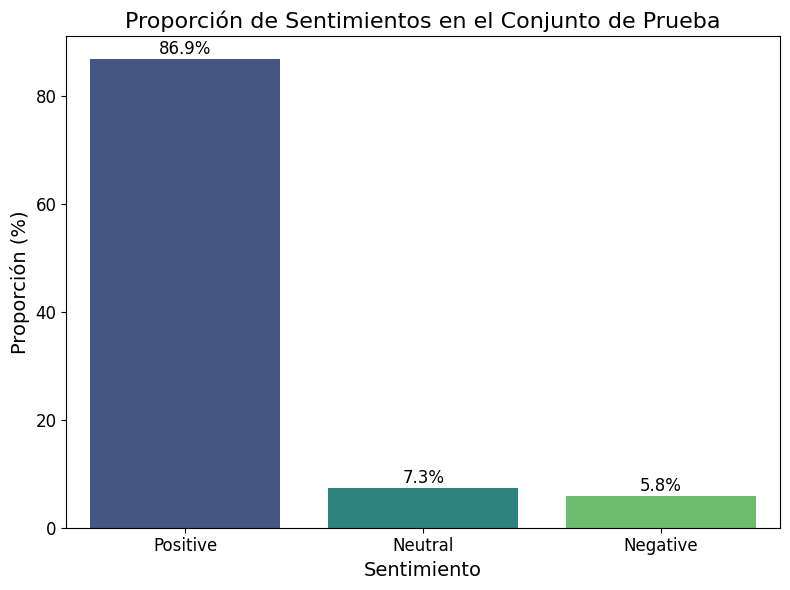

In [19]:
### VISUALIZACIÓN DEL ANÁLISIS DE SENTIMIENTO PARA EL CONJUNTO DE PRUEBA

plt.figure(figsize=(8, 6))
sentiment_counts = test_df['sentiment'].value_counts(normalize=True) * 100
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", hue=sentiment_counts.index)
plt.xlabel('Sentimiento', size=14)
plt.ylabel('Proporción (%)', size=14)
plt.title('Proporción de Sentimientos en el Conjunto de Prueba', size=16)
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', size=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

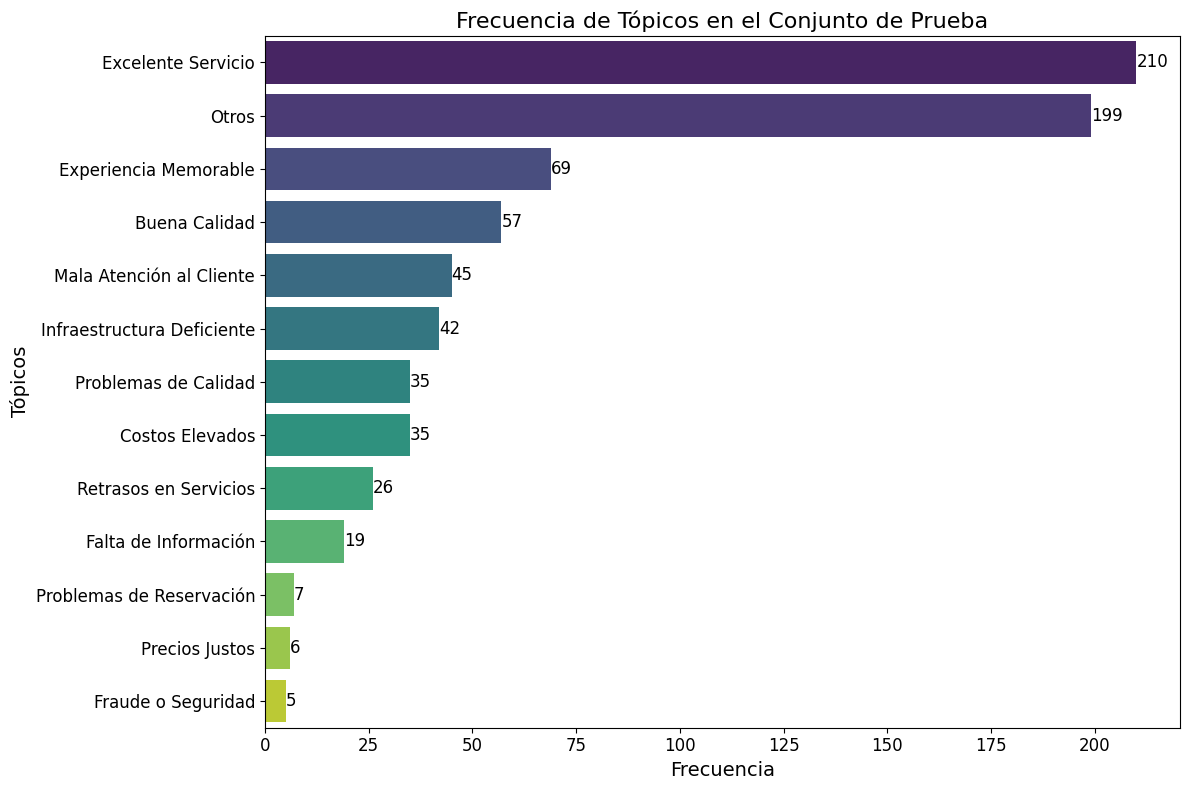

In [20]:
### VISUALIZACIÓN DE LA CLASIFICACIÓN DE TÓPICOS

plt.figure(figsize=(12, 8))
issue_counts = test_df['issue'].value_counts()
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette="viridis", hue=issue_counts.index)
plt.xlabel('Frecuencia', size=14)
plt.ylabel('Tópicos', size=14)
plt.title('Frecuencia de Tópicos en el Conjunto de Prueba', size=16)
for i, v in enumerate(issue_counts.values):
    plt.text(v, i, str(v), va='center', size=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()